In [1]:
# 1. Get essential libraries
from vnstock import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

Observations:  1640


<Axes: xlabel='Time'>

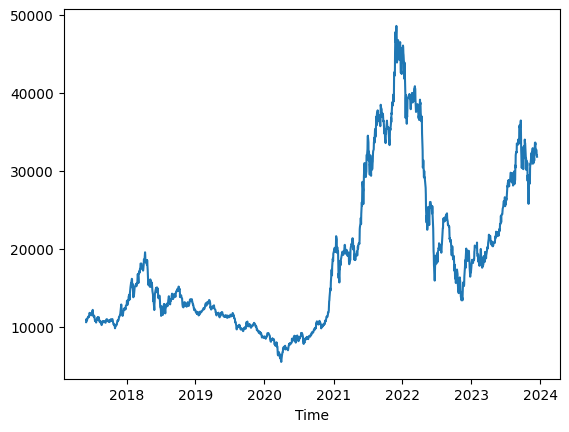

In [2]:
#2. Fetch data and visualize
# SSI
SSI = stock_historical_data(symbol = "SSI", start_date="2017-06-01", end_date="2023-12-15", resolution="1D", type = "stock", beautify=True, decor=True, source = "DNSE")
from matplotlib import pyplot
print("Observations: ",len(SSI['Close']))
SSI["Close"].plot()

In [3]:
# Preprocessing
df = pd.DataFrame(SSI['Close'])
df = df.dropna() 
df = df.reset_index(drop=True)
df

,Close
0,10570
1,10950
2,10740
3,10870
4,10980
...,...
1635,32700
1636,32600
1637,32000
1638,32000


In [4]:
# Check stationary
from statsmodels.tsa.stattools import adfuller
adf1 = adfuller(df['Close'], regression ='c', maxlag=30)
print("ADF stat: %f" % adf1[0])
print("p-value: %f" % adf1[1])
#Not stationary

ADF stat: -1.139246
p-value: 0.699170


In [5]:
adf2 = adfuller(df['Close'].diff().dropna(), regression ='c', maxlag=30)
print("ADF stat: %f" % adf2[0])
print("p-value: %f" % adf2[1])
#Stationary

ADF stat: -16.253531
p-value: 0.000000


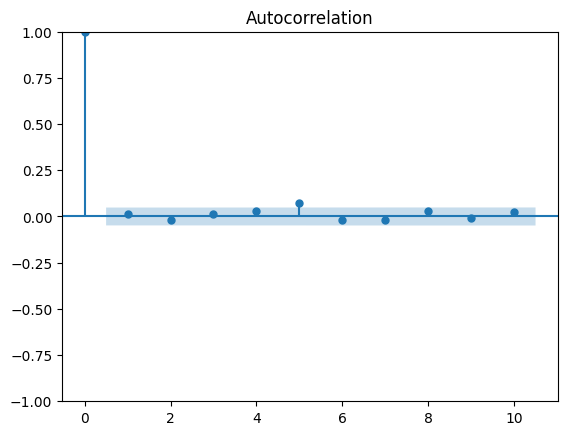

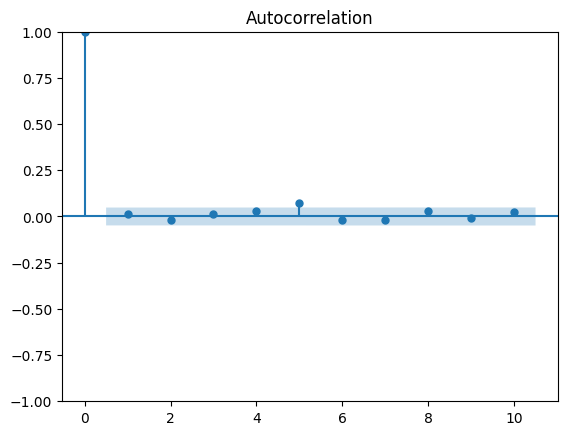

In [6]:
# Difference the data and plot the acf
#ACF
sm.tsa.acf(np.diff(df['Close']), nlags=10)
sm.graphics.tsa.plot_acf(np.diff(df['Close']),lags=10)

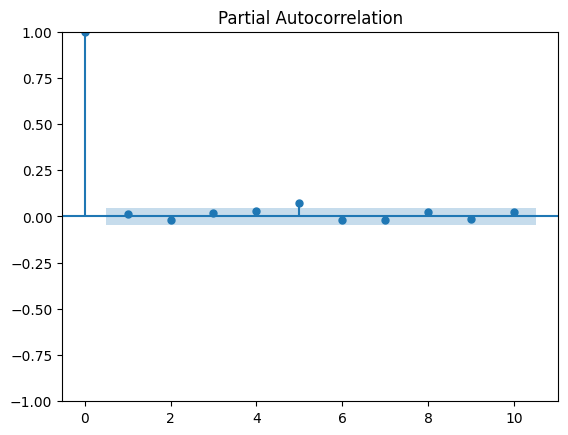

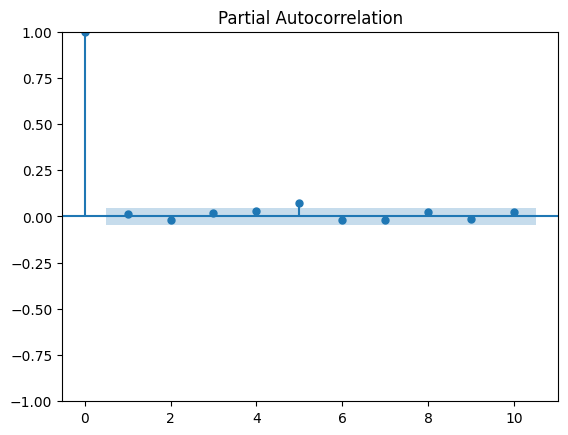

In [7]:
# Difference the data and plot the pacf
# PACF
sm.tsa.pacf(np.diff(df['Close']), nlags=10)
sm.graphics.tsa.plot_pacf(np.diff(df['Close']),lags=10)

In [8]:
#3. Slit the data into train : 
# Test with ratio 8:2
train_size82 = int(0.8 * len(df))
test_size82 = int(0.2 * len(df))

train_data82 = df[:train_size82]
test_data82 = df[train_size82:]

In [9]:
# 4. Training process
# 8 : 2 RATIO
x_train82 = np.array(train_data82.index).reshape(-1, 1)
y_train82 = np.array(train_data82['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

model82 = auto_arima(y_train82, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model_fit82 = model82.fit(y_train82)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20295.106, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20293.729, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20293.655, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20293.543, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=20295.570, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.069 seconds


In [10]:
# 5. Testing process
# 8:2 RATIO
x_test82 = np.array(test_data82.index).reshape(-1, 1)
y_test82 = np.array(test_data82['Close'])
y_pred82 = model82.predict(n_periods=len(y_test82))
len(y_pred82)

328

In [11]:
# 6. 60 days prediction
# 8:2 RATIO
last_index82 =  df.index[-1]
last_data82 =pd.RangeIndex(start=last_index82, stop=last_index82 + 60, step=1)

#create an array of 60 integers starting from last index
x_next_60_days82 = np.array(range(last_index82 + 1, last_index82 + 61)).reshape(-1, 1)

#predict the price for the next 60 days.
y_next_60_days82 = model82.predict(len(x_next_60_days82))

#print the prices for the next 60 days.
print('Predicted prices for the next 60 days: ')
print(y_next_60_days82)

Predicted prices for the next 60 days: 
[23860. 23860. 23860. 23860. 23860. 23860. 23860. 23860. 23860. 23860.
 23860. 23860. 23860. 23860. 23860. 23860. 23860. 23860. 23860. 23860.
 23860. 23860. 23860. 23860. 23860. 23860. 23860. 23860. 23860. 23860.
 23860. 23860. 23860. 23860. 23860. 23860. 23860. 23860. 23860. 23860.
 23860. 23860. 23860. 23860. 23860. 23860. 23860. 23860. 23860. 23860.
 23860. 23860. 23860. 23860. 23860. 23860. 23860. 23860. 23860. 23860.]


In [14]:
# 7. Evaluation
# 8 : 2 RATIO
#RMSE
test_rmse = np.sqrt(np.mean((y_pred82 - y_test82)**2))
print('Testing RMSE:', test_rmse)

#MAPE
test_mape = np.mean(np.abs((y_test82 - y_pred82) / y_test82)) * 100
print('Testing MAPE:', test_mape)

#MAE
test_mae = np.mean(np.abs(y_pred82 - y_test82))
print('Testing MAE:', test_mae)

def MSLE (pred, actual):
    return np.mean((np.log(1+actual)-np.log(1+pred))*(np.log(1+actual)-np.log(1+pred)))
print("Testing MSLR: ", MSLE(y_pred82, y_test82))

Testing RMSE: 6094.899898135545
Testing MAPE: 24.49739256660258
Testing MAE: 5461.945121951219
Testing MSLR:  0.06790233242585321


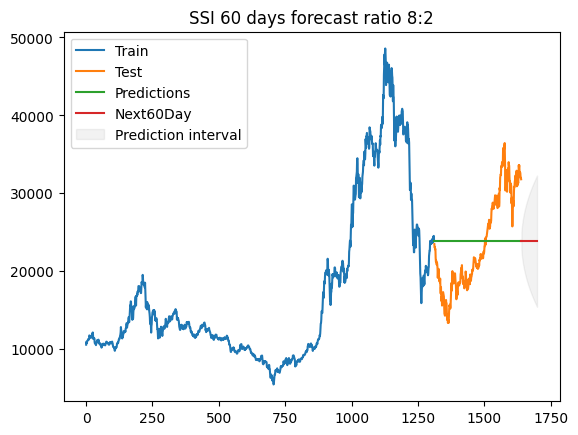

In [13]:
# 8:2 RATIO
# Forecast
n_periods = 60
fc, confint = model_fit82.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df['Close']), len(df['Close'])+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(train_data82.index, train_data82['Close'])
plt.plot(test_data82.index, test_data82['Close'])
plt.plot(test_data82.index, y_pred82)

plt.plot(fc_series)
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.05)
plt.legend(['Train', 'Test', 'Predictions','Next60Day', 'Prediction interval'])

plt.title("SSI 60 days forecast ratio 8:2")
plt.show()

In [16]:
#Forecast with ARIMA(2, 1, 2)
model82 = sm.tsa.arima.ARIMA(
    train_data82,
    order = (2,1,2)
).fit()
model82.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1312
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -10141.863
Date:                Wed, 27 Dec 2023   AIC                          20293.727
Time:                        17:59:12   BIC                          20319.619
Sample:                             0   HQIC                         20303.438
                               - 1312                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5918      0.385      1.536      0.125      -0.164       1.347
ar.L2          0.3526      0.353      0.999      0.318      -0.339       1.045
ma.L1         -0.5413      0.381     -1.421      0.155      -1.288       0.205
ma.L2         -0.3782      0.338     -1.118      0.263      -1.041       0.285
sigma2      3.074e+05   6254.055     49.154      0.000    2.95e+05     3.2e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              1837.62
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               7.59   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
# 5. Testing process
# 8:2 RATIO
x_test82 = np.array(test_data82.index).reshape(-1, 1)
y_test82 = np.array(test_data82['Close'])
y_pred82 = model82.predict(start = train_size82, end = train_size82+test_size82)
y_pred82

1312    23849.592067
1313    23878.001088
1314    23891.143030
1315    23908.936559
1316    23924.099851
            ...     
1636    24294.162560
1637    24294.162586
1638    24294.162610
1639    24294.162633
1640    24294.162656
Name: predicted_mean, Length: 329, dtype: float64

In [18]:
# 6. 60 days prediction
# 8:2 RATIO
last_index82 =  df.index[-1]
last_data82 =pd.RangeIndex(start=last_index82, stop=last_index82 + 60, step=1)

#create an array of 60 integers starting from last index
x_next_60_days82 = np.array(range(last_index82 + 1, last_index82 + 61)).reshape(-1, 1)

#predict the price for the next 60 days.
y_next_60_days82 = model82.predict(len(x_next_60_days82))

#print the prices for the next 60 days.
print('Predicted prices for the next 60 days: ')
print(y_next_60_days82)

Predicted prices for the next 60 days: 
60      10307.975837
61      10332.448684
62      10470.941630
63      10684.923098
64      10562.081853
            ...     
1307    24226.731541
1308    23770.806641
1309    24501.575792
1310    24302.405832
1311    24575.968574
Name: predicted_mean, Length: 1252, dtype: float64


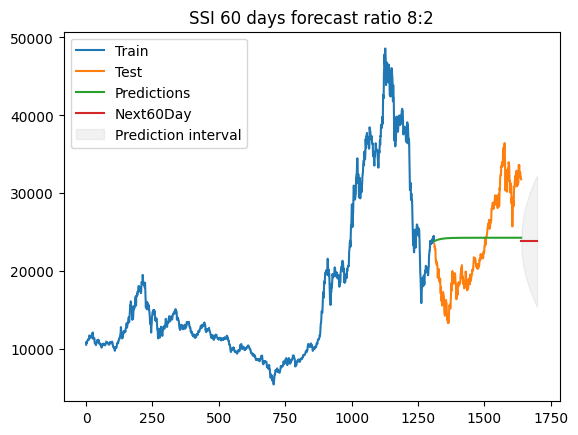

In [26]:
# 8:2 RATIO
# Forecast
n_periods = 60
fc, confint = model_fit82.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df['Close']), len(df['Close'])+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(train_data82.index, train_data82['Close'])
plt.plot(test_data82.index, test_data82['Close'])
plt.plot(test_data82.index, y_pred82[:328])

plt.plot(fc_series)
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.05)
plt.legend(['Train', 'Test', 'Predictions','Next60Day', 'Prediction interval'])

plt.title("SSI 60 days forecast ratio 8:2")
plt.show()